In [1]:
# numerical module
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import fsolve

#setup plotting 
import matplotlib.pyplot as plt
plt.style.use('SciencePlots-APS.mplstyle')

In [2]:
class DBMModel:
    egapMax = 15.0  # [eV]
    
    def __init__(self):
        self.c = 299792458.0            # [m/s]
        self.h = 4.135667696e-15        # [eV.s]
        self.e = 1.602176634e-19        # [C]
        self.kB = 8.617333262e-05       # [eV/K]
    
    def photon_flux(self, temp, mu, egap):
        const = (2. * np.pi) / (self.c ** 2 * self.h ** 3)
        integrand = lambda E: (E ** 2) / (np.exp((E - mu) / (self.kB * temp)) - 1.)
        integral, _ = integrate.quad(integrand, egap, self.egapMax)
        return const * integral
    
    def current_density(self, mu, temp_cell, temp_amb, egap):
        flux_Ta = self.photon_flux(temp_amb, 0.0, egap)
        flux_tc = self.photon_flux(temp_cell, mu, egap)
        return self.e * (flux_Ta - flux_tc)
    
    def radiative_energy_flux(self, temp, mu, egap):
        const = (2. * np.pi) / (self.c ** 2 * self.h ** 3)
        integrand = lambda E: (E ** 3) / (np.exp((E - mu) / (self.kB * temp)) - 1.)
        integral, _ = integrate.quad(integrand, egap, self.egapMax)
        return self.e * const * integral
    
    def power_density(self, temp_cell, temp_amb, mu, egap):
        flux_Ta = self.photon_flux(temp_amb, 0.0, egap)
        flux_tc = self.photon_flux(temp_cell, mu, egap)
        return self.e * mu * (flux_Ta - flux_tc)
    
    def efficiency(self, temp_cell, temp_amb, mu, egap):
        Erad = self.radiative_energy_flux(temp_cell, mu, egap)
        Eabs = self.radiative_energy_flux(temp_amb, 0.0, egap)
        PD = self.power_density(temp_cell, temp_amb, mu, egap)
        return np.divide(PD, (PD + Erad - Eabs)) 
    
    def find_mu(self, temp_cell, temp_amb, egap):
        mu = fsolve(self.current_density, 0.0, args=(temp_cell, temp_amb, egap))
        return mu[0] 
    
    def carnot_efficiency(self, temp_cell, temp_amb):
        return 1.0 - (temp_amb / temp_cell)
    
    def radiative_heat_flux_below_egap(self, temp, egap):
        const = (2. * np.pi) / (self.c ** 2 * self.h ** 3)
        integrand = lambda E: (E ** 3) / (np.exp((E) / (self.kB * temp)) - 1.)
        integral, _ = integrate.quad(integrand, 0.0, egap)
        return self.e * const * integral
        
    def efficiency_with_subbandgap_losses(self, temp_cell, temp_amb, mu, egap):        
        PD = self.power_density(temp_cell, temp_amb, mu, egap)
        EabsAboveEgap = self.radiative_energy_flux(temp_amb, 0.0, egap)
        EradAboveEgap = self.radiative_energy_flux(temp_cell, mu, egap)
        EabsBelowEgap = self.radiative_heat_flux_below_egap(temp_amb, egap)
        EradBelowEgap = self.radiative_heat_flux_below_egap(temp_cell, egap)
        return np.divide(PD, (PD + EradAboveEgap+ EradBelowEgap - EabsAboveEgap -EabsBelowEgap))
    
cellTRDBM = DBMModel()

In [3]:
# parameter
EgapGaAs = 1.016  #[eV]
EgapGaSb = 0.554  #[eV]
EgapInAs = 0.209  #[eV]
EgapInP = 1.240  #[eV]

Tamb = 300.0                             # ambient temperature [K]
Tcell = np.array([500.0, 750.0, 1000.0])   # cell temperature [K]

## GaAs

In [4]:
# determine mu_voc
muVOCGaAs500 = np.round(cellTRDBM.find_mu(Tcell[0], Tamb, EgapGaAs),decimals=6)
muVOCGaAs750 = np.round(cellTRDBM.find_mu(Tcell[1], Tamb, EgapGaAs),decimals=6)
muVOCGaAs1000 = np.round(cellTRDBM.find_mu(Tcell[2], Tamb, EgapGaAs),decimals=6)

print('mu_VOC GaAs (T = {} K) = {} eV'.format(Tcell[0], muVOCGaAs500))
print('mu_VOC GaAs (T = {} K) = {} eV'.format(Tcell[1], muVOCGaAs750))
print('mu_VOC GaAs (T = {} K) = {} eV'.format(Tcell[2], muVOCGaAs1000))

mu_VOC GaAs (T = 500.0 K) = -0.7005 eV
mu_VOC GaAs (T = 750.0 K) = -1.587665 eV
mu_VOC GaAs (T = 1000.0 K) = -2.483964 eV


In [5]:
# mu list
muListGaAs500 = np.linspace(muVOCGaAs500, 0.0, 501)
muListGaAs750 = np.linspace(muVOCGaAs750, 0.0, 501)
muListGaAs1000 = np.linspace(muVOCGaAs1000, 0.0, 501)

# power density
PowerDensityGaAs500 = np.array([cellTRDBM.power_density(Tcell[0], Tamb, x, EgapGaAs) for x in muListGaAs500])
PowerDensityGaAs750 = np.array([cellTRDBM.power_density(Tcell[1], Tamb, x, EgapGaAs) for x in muListGaAs750])
PowerDensityGaAs1000 = np.array([cellTRDBM.power_density(Tcell[2], Tamb, x, EgapGaAs) for x in muListGaAs1000])

# efficiency w/o losses
EfficiencyWithOutLossesGaAs500 = np.array([cellTRDBM.efficiency(Tcell[0], Tamb, x, EgapGaAs) for x in muListGaAs500])
EfficiencyWithOutLossesGaAs750 = np.array([cellTRDBM.efficiency(Tcell[1], Tamb, x, EgapGaAs) for x in muListGaAs750])
EfficiencyWithOutLossesGaAs1000 = np.array([cellTRDBM.efficiency(Tcell[2], Tamb, x, EgapGaAs) for x in muListGaAs1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesGaAs500 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[0], Tamb, x, EgapGaAs) for x in muListGaAs500])
EfficiencywithSubBandGapLossesGaAs750 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[1], Tamb, x, EgapGaAs) for x in muListGaAs750])
EfficiencywithSubBandGapLossesGaAs1000 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[2], Tamb, x, EgapGaAs) for x in muListGaAs1000])

## GaSb

In [6]:
# determine mu_voc
muVOCGaSb500 = np.round(cellTRDBM.find_mu(Tcell[0], Tamb, EgapGaSb),decimals=6)
muVOCGaSb750 = np.round(cellTRDBM.find_mu(Tcell[1], Tamb, EgapGaSb),decimals=6)
muVOCGaSb1000 = np.round(cellTRDBM.find_mu(Tcell[2], Tamb, EgapGaSb),decimals=6)

print('mu_VOC GaSb (T = {} K) = {} eV'.format(Tcell[0], muVOCGaSb500))
print('mu_VOC GaSb (T = {} K) = {} eV'.format(Tcell[1], muVOCGaSb750))
print('mu_VOC GaSb (T = {} K) = {} eV'.format(Tcell[2], muVOCGaSb1000))

mu_VOC GaSb (T = 500.0 K) = -0.393711 eV
mu_VOC GaSb (T = 750.0 K) = -0.898711 eV
mu_VOC GaSb (T = 1000.0 K) = -1.414251 eV


In [7]:
# mu list
muListGaSb500 = np.linspace(muVOCGaSb500, 0.0, 501)
muListGaSb750 = np.linspace(muVOCGaSb750, 0.0, 501)
muListGaSb1000 = np.linspace(muVOCGaSb1000, 0.0, 501)

# power density
PowerDensityGaSb500 = np.array([cellTRDBM.power_density(Tcell[0], Tamb, x, EgapGaSb) for x in muListGaSb500])
PowerDensityGaSb750 = np.array([cellTRDBM.power_density(Tcell[1], Tamb, x, EgapGaSb) for x in muListGaSb750])
PowerDensityGaSb1000 = np.array([cellTRDBM.power_density(Tcell[2], Tamb, x, EgapGaSb) for x in muListGaSb1000])

# efficiency w/o losses
EfficiencyWithOutLossesGaSb500 = np.array([cellTRDBM.efficiency(Tcell[0], Tamb, x, EgapGaSb) for x in muListGaSb500])
EfficiencyWithOutLossesGaSb750 = np.array([cellTRDBM.efficiency(Tcell[1], Tamb, x, EgapGaSb) for x in muListGaSb750])
EfficiencyWithOutLossesGaSb1000 = np.array([cellTRDBM.efficiency(Tcell[2], Tamb, x, EgapGaSb) for x in muListGaSb1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesGaSb500 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[0], Tamb, x, EgapGaSb) for x in muListGaSb500])
EfficiencywithSubBandGapLossesGaSb750 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[1], Tamb, x, EgapGaSb) for x in muListGaSb750])
EfficiencywithSubBandGapLossesGaSb1000 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[2], Tamb, x, EgapGaSb) for x in muListGaSb1000])

## InAs 

In [8]:
# determine mu_voc
muVOCInAs500 = np.round(cellTRDBM.find_mu(Tcell[0], Tamb, EgapInAs),decimals=6)
muVOCInAs750 = np.round(cellTRDBM.find_mu(Tcell[1], Tamb, EgapInAs),decimals=6)
muVOCInAs1000 = np.round(cellTRDBM.find_mu(Tcell[2], Tamb, EgapInAs),decimals=6)

print('mu_VOC InAs (T = {} K) = {} eV'.format(Tcell[0], muVOCInAs500))
print('mu_VOC InAs (T = {} K) = {} eV'.format(Tcell[1], muVOCInAs750))
print('mu_VOC InAs (T = {} K) = {} eV'.format(Tcell[2], muVOCInAs1000))

mu_VOC InAs (T = 500.0 K) = -0.168164 eV
mu_VOC InAs (T = 750.0 K) = -0.395197 eV
mu_VOC InAs (T = 1000.0 K) = -0.636817 eV


In [9]:
# mu list
muListInAs500 = np.linspace(muVOCInAs500, 0.0, 501)
muListInAs750 = np.linspace(muVOCInAs750, 0.0, 501)
muListInAs1000 = np.linspace(muVOCInAs1000, 0.0, 501)

# power density
PowerDensityInAs500 = np.array([cellTRDBM.power_density(Tcell[0], Tamb, x, EgapInAs) for x in muListInAs500])
PowerDensityInAs750 = np.array([cellTRDBM.power_density(Tcell[1], Tamb, x, EgapInAs) for x in muListInAs750])
PowerDensityInAs1000 = np.array([cellTRDBM.power_density(Tcell[2], Tamb, x, EgapInAs) for x in muListInAs1000])

# efficiency w/o losses
EfficiencyWithOutLossesInAs500 = np.array([cellTRDBM.efficiency(Tcell[0], Tamb, x, EgapInAs) for x in muListInAs500])
EfficiencyWithOutLossesInAs750 = np.array([cellTRDBM.efficiency(Tcell[1], Tamb, x, EgapInAs) for x in muListInAs750])
EfficiencyWithOutLossesInAs1000 = np.array([cellTRDBM.efficiency(Tcell[2], Tamb, x, EgapInAs) for x in muListInAs1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesInAs500 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[0], Tamb, x, EgapInAs) for x in muListInAs500])
EfficiencywithSubBandGapLossesInAs750 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[1], Tamb, x, EgapInAs) for x in muListInAs750])
EfficiencywithSubBandGapLossesInAs1000 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[2], Tamb, x, EgapInAs) for x in muListInAs1000])

## InP

In [10]:
# determine mu_voc
muVOCInP500 = np.round(cellTRDBM.find_mu(Tcell[0], Tamb, EgapInP),decimals=6)
muVOCInP750 = np.round(cellTRDBM.find_mu(Tcell[1], Tamb, EgapInP),decimals=6)
muVOCInP1000 = np.round(cellTRDBM.find_mu(Tcell[2], Tamb, EgapInP),decimals=6)

print('mu_VOC InP (T = {} K) = {} eV'.format(Tcell[0], muVOCInP500))
print('mu_VOC InP (T = {} K) = {} eV'.format(Tcell[1], muVOCInP750))
print('mu_VOC InP (T = {} K) = {} eV'.format(Tcell[2], muVOCInP1000))

mu_VOC InP (T = 500.0 K) = -0.849579 eV
mu_VOC InP (T = 750.0 K) = -1.922795 eV
mu_VOC InP (T = 1000.0 K) = -3.004825 eV


In [11]:
# mu list
muListInP500 = np.linspace(muVOCInP500, 0.0, 501)
muListInP750 = np.linspace(muVOCInP750, 0.0, 501)
muListInP1000 = np.linspace(muVOCInP1000, 0.0, 501)

# power density
PowerDensityInP500 = np.array([cellTRDBM.power_density(Tcell[0], Tamb, x, EgapInP) for x in muListInP500])
PowerDensityInP750 = np.array([cellTRDBM.power_density(Tcell[1], Tamb, x, EgapInP) for x in muListInP750])
PowerDensityInP1000 = np.array([cellTRDBM.power_density(Tcell[2], Tamb, x, EgapInP) for x in muListInP1000])

# efficiency w/o losses
EfficiencyWithOutLossesInP500 = np.array([cellTRDBM.efficiency(Tcell[0], Tamb, x, EgapInP) for x in muListInP500])
EfficiencyWithOutLossesInP750 = np.array([cellTRDBM.efficiency(Tcell[1], Tamb, x, EgapInP) for x in muListInP750])
EfficiencyWithOutLossesInP1000 = np.array([cellTRDBM.efficiency(Tcell[2], Tamb, x, EgapInP) for x in muListInP1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesInP500 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[0], Tamb, x, EgapInP) for x in muListInP500])
EfficiencywithSubBandGapLossesInP750 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[1], Tamb, x, EgapInP) for x in muListInP750])
EfficiencywithSubBandGapLossesInP1000 = np.array([cellTRDBM.efficiency_with_subbandgap_losses(Tcell[2], Tamb, x, EgapInP) for x in muListInP1000])

## Summary

In [12]:
# determine maximum power density
## GaAs
MaxPowerDensityGaAs500 = np.max(PowerDensityGaAs500)
MaxPowerDensityGaAs750 = np.max(PowerDensityGaAs750)
MaxPowerDensityGaAs1000 = np.max(PowerDensityGaAs1000)
## GaSb
MaxPowerDensityGaSb500 = np.max(PowerDensityGaSb500)
MaxPowerDensityGaSb750 = np.max(PowerDensityGaSb750)
MaxPowerDensityGaSb1000 = np.max(PowerDensityGaSb1000)
## InAs
MaxPowerDensityInAs500 = np.max(PowerDensityInAs500)
MaxPowerDensityInAs750 = np.max(PowerDensityInAs750)
MaxPowerDensityInAs1000 = np.max(PowerDensityInAs1000)
## InP
MaxPowerDensityInP500 = np.max(PowerDensityInP500)
MaxPowerDensityInP750 = np.max(PowerDensityInP750)
MaxPowerDensityInP1000 = np.max(PowerDensityInP1000)

# determine maximum efficiency without losses
## GaAs
MaxEfficiencyWithOutLossesGaAs500 = np.max(EfficiencyWithOutLossesGaAs500*100)
MaxEfficiencyWithOutLossesGaAs750 = np.max(EfficiencyWithOutLossesGaAs750*100)
MaxEfficiencyWithOutLossesGaAs1000 = np.max(EfficiencyWithOutLossesGaAs1000*100)
## GaSb
MaxEfficiencyWithOutLossesGaSb500 = np.max(EfficiencyWithOutLossesGaSb500*100)
MaxEfficiencyWithOutLossesGaSb750 = np.max(EfficiencyWithOutLossesGaSb750*100)
MaxEfficiencyWithOutLossesGaSb1000 = np.max(EfficiencyWithOutLossesGaSb1000*100)
## InAs
MaxEfficiencyWithOutLossesInAs500 = np.max(EfficiencyWithOutLossesInAs500*100)
MaxEfficiencyWithOutLossesInAs750 = np.max(EfficiencyWithOutLossesInAs750*100)
MaxEfficiencyWithOutLossesInAs1000 = np.max(EfficiencyWithOutLossesInAs1000*100)
## InP
MaxEfficiencyWithOutLossesInP500 = np.max(EfficiencyWithOutLossesInP500*100)
MaxEfficiencyWithOutLossesInP750 = np.max(EfficiencyWithOutLossesInP750*100)
MaxEfficiencyWithOutLossesInP1000 = np.max(EfficiencyWithOutLossesInP1000*100)

# determine maximum efficiency with losses
## GaAs
MaxEfficiencyWithLossesGaAs500 = np.max(EfficiencywithSubBandGapLossesGaAs500*100)
MaxEfficiencyWithLossesGaAs750 = np.max(EfficiencywithSubBandGapLossesGaAs750*100)
MaxEfficiencyWithLossesGaAs1000 = np.max(EfficiencywithSubBandGapLossesGaAs1000*100)
## GaSb
MaxEfficiencyWithLossesGaSb500 = np.max(EfficiencywithSubBandGapLossesGaSb500*100)
MaxEfficiencyWithLossesGaSb750 = np.max(EfficiencywithSubBandGapLossesGaSb750*100)
MaxEfficiencyWithLossesGaSb1000 = np.max(EfficiencywithSubBandGapLossesGaSb1000*100)
## InAs
MaxEfficiencyWithLossesInAs500 = np.max(EfficiencywithSubBandGapLossesInAs500*100)
MaxEfficiencyWithLossesInAs750 = np.max(EfficiencywithSubBandGapLossesInAs750*100)
MaxEfficiencyWithLossesInAs1000 = np.max(EfficiencywithSubBandGapLossesInAs1000*100)
## InP
MaxEfficiencyWithLossesInP500 = np.max(EfficiencywithSubBandGapLossesInP500*100)
MaxEfficiencyWithLossesInP750 = np.max(EfficiencywithSubBandGapLossesInP750*100)
MaxEfficiencyWithLossesInP1000 = np.max(EfficiencywithSubBandGapLossesInP1000*100)

In [13]:
# print all summary result
print('#---------------------------#')
print('# GaAs (Eg = {} eV)'.format(EgapGaAs))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityGaAs500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityGaAs750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityGaAs1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesGaAs500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesGaAs750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesGaAs1000))
print('')
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[0], MaxEfficiencyWithLossesGaAs500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesGaAs750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesGaAs1000))
print('#---------------------------#')
print('')
print('#---------------------------#')
print('# GaSb (Eg = {} eV)'.format(EgapGaSb))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityGaSb500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityGaSb750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityGaSb1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesGaSb500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesGaSb750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesGaSb1000))
print('')
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[0], MaxEfficiencyWithLossesGaSb500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesGaSb750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesGaSb1000))
print('#---------------------------#')
print('')
print('#---------------------------#')
print('# InAs (Eg = {} eV)'.format(EgapInAs))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityInAs500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityInAs750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityInAs1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesInAs500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesInAs750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesInAs1000))
print('')
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[0], MaxEfficiencyWithLossesInAs500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesInAs750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesInAs1000))
print('#---------------------------#')
print('')
print('#---------------------------#')
print('# InP (Eg = {} eV)'.format(EgapInP))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityInP500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityInP750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityInP1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesInP500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesInP750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesInP1000))
print('')
print('eta_max w losses ({} K) = {:.7f} %'.format(Tcell[0], MaxEfficiencyWithLossesInP500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesInP750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesInP1000))
print('#---------------------------#')
print('')

#---------------------------#
# GaAs (Eg = 1.016 eV)
#---------------------------#
P_max (500.0 K) = 0.000007 W/m^2
P_max (750.0 K) = 0.042443 W/m^2
P_max (1000.0 K) = 4.005974 W/m^2

eta_max w/o losses (500.0 K) = 38.30176 %
eta_max w/o losses (750.0 K) = 57.71813 %
eta_max w/o losses (1000.0 K) = 67.45575 %

eta_max w losses (500.0 K) = 0.000000 %
eta_max w losses (750.0 K) = 0.000243 %
eta_max w losses (1000.0 K) = 0.007133 %
#---------------------------#

#---------------------------#
# GaSb (Eg = 0.554 eV)
#---------------------------#
P_max (500.0 K) = 0.100955 W/m^2
P_max (750.0 K) = 17.826172 W/m^2
P_max (1000.0 K) = 291.394388 W/m^2

eta_max w/o losses (500.0 K) = 36.85582 %
eta_max w/o losses (750.0 K) = 55.69306 %
eta_max w/o losses (1000.0 K) = 65.11439 %

eta_max w losses (500.0 K) = 0.003275 %
eta_max w losses (750.0 K) = 0.103643 %
eta_max w losses (1000.0 K) = 0.553862 %
#---------------------------#

#---------------------------#
# InAs (Eg = 0.209 eV)
#---------------

## Summary data

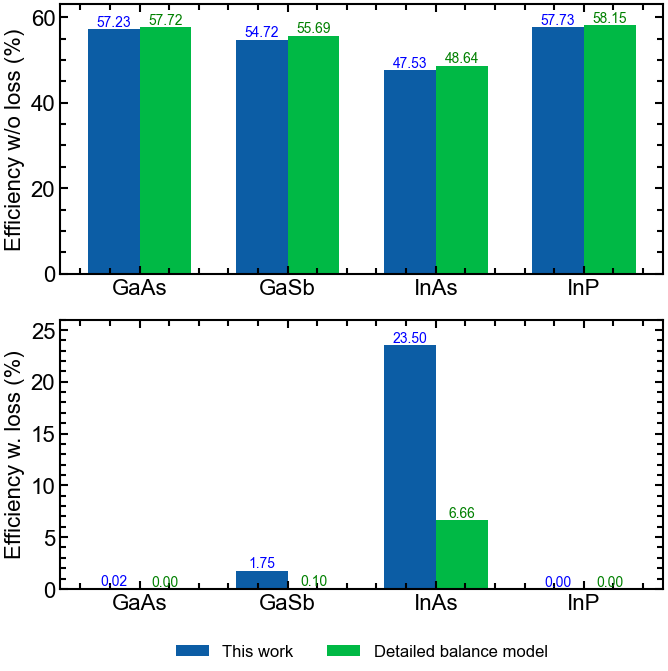

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Data
Material = ['GaAs', 'GaSb', 'InAs', 'InP']
EgapMaterial = np.array([EgapGaAs, EgapGaSb, EgapInAs, EgapInP])
this_work_EtaWOLoss = np.array([57.23028188, 54.72361039, 47.5346855, 57.72992509])
this_work_EtaWLLoss = np.array([0.0173979603, 1.75486715, 23.4998823, 0.00143875955])
detailed_balance_EtaWOLoss = np.array([57.71813427, 55.69305874, 48.64338812, 58.1466546])
detailed_balance_EtaWLLoss = np.array([0.000242795243, 0.10364337, 6.65873148, 0.0000110451496])

# Plotting
x = np.arange(len(Material))  # X-axis locations for bars
width = 0.35  # Width of the bars

# Bar chart for Eta with out losses
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
rects1 = ax[0].bar(x - width/2, this_work_EtaWOLoss, width, label='This work')
rects2 = ax[0].bar(x + width/2, detailed_balance_EtaWOLoss, width, label='Detailed balance model')

# Add text annotations for each bar
for i, (r1, r2) in enumerate(zip(rects1, rects2)):
    ax[0].text(r1.get_x() + r1.get_width() / 2, r1.get_height(), f"{this_work_EtaWOLoss[i]:.2f}", ha='center', va='bottom',fontsize=10, color='blue')
    ax[0].text(r2.get_x() + r2.get_width() / 2, r2.get_height(), f"{detailed_balance_EtaWOLoss[i]:.2f}", ha='center', va='bottom', fontsize=10, color='green')

# Add labels and title
ax[0].set_ylabel('Efficiency w/o loss (%)', fontsize=16)
ax[0].set_xticks(x)
ax[0].set_xticklabels(Material, fontsize=16)
ax[0].set_ylim(0.0, 63.0)


# Bar chart for EtaWLLoss
rects1 = ax[1].bar(x - width/2, this_work_EtaWLLoss, width, label='This work')
rects2 = ax[1].bar(x + width/2, detailed_balance_EtaWLLoss, width, label='Detailed balance model')

# Add text annotations for each bar
for i, (r1, r2) in enumerate(zip(rects1, rects2)):
    ax[1].text(r1.get_x() + r1.get_width() / 2, r1.get_height(), f"{this_work_EtaWLLoss[i]:.2f}", ha='center', va='bottom', fontsize=10, color='blue')
    ax[1].text(r2.get_x() + r2.get_width() / 2, r2.get_height(), f"{detailed_balance_EtaWLLoss[i]:.2f}", ha='center', va='bottom', fontsize=10, color='green')

# Add labels, title, and legend
ax[1].set_ylabel('Efficiency w. loss (%)', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xticklabels(Material, fontsize=16)
ax[1].set_ylim(0.0, 26.0)

# Move the legend outside the figure
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

fig.tight_layout()

fig.savefig('./imag/comparison-TRcell-performance.svg')

plt.show()